# In this notebook
I write code to generate the synthetic unobserved confound data so that we have a known (but chosen unobserved confounder).

In [13]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import rasterio as rio

In [2]:
# Get the shape of the reference data
with rio.open('../data/durham/durham_ndvi.tif') as src:
    # Get the shape of the original data
    orig_shape = src.shape

In [188]:
# Create a grid that uses every 10th pixel from the original data
sr = 50 # Create a sample resolution of every 50 pixels to reduce computation time

x, y = np.meshgrid(np.arange(0, orig_shape[1]+sr*2, sr), np.arange(0, orig_shape[0]+2*sr, sr))

X = np.vstack((x.flatten(), y.flatten())).T

In [182]:
# Create the kernel
def kernel(x1, x2, a=1, l=1):
    sqdist = np.sum(x1**2, 1).reshape(-1,1) + np.sum(x2**2, 1) - 2 * np.dot(x1, x2.T)

    return a * np.exp(-0.5*sqdist / l**2)

In [183]:
np.random.seed(42)  # For reproducibility
K = kernel(X, X, l=200)
mu = np.zeros(X.shape[0])

z = np.random.multivariate_normal(mu, K, 1)

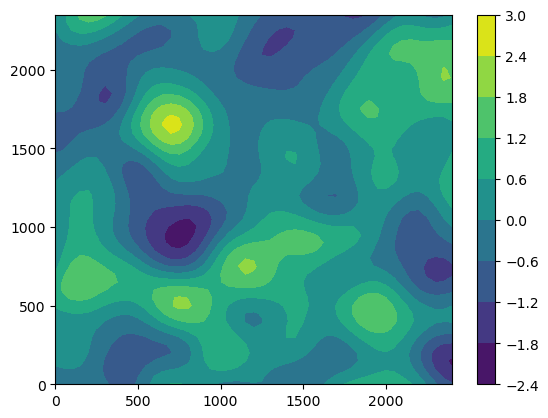

In [184]:
plt.contourf(x, y, z.reshape(x.shape))
plt.colorbar()

The code above generates the data, but we want it at a higher resolution, so I am going to apply a cubic spline to fill in the gaps between the points.

In [194]:
from scipy.interpolate import griddata

# Create the interpolator
new_x, new_y = np.meshgrid(np.arange(0, orig_shape[1]), np.arange(0, orig_shape[0]))
new_X = np.vstack((new_x.flatten(), new_y.flatten())).T
U = griddata(X, z.flatten(), new_X, method='cubic')
U = U.reshape(new_x.shape)


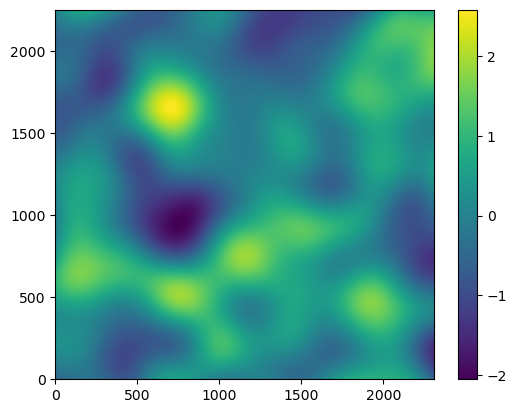

In [195]:
plt.imshow(U, origin='lower')
plt.colorbar()
plt.show()

In [197]:
# Save the result as a TIF
# Get the metadata from the original file
with rio.open('../data/durham/durham_ndvi.tif') as src:
    meta = src.meta

# Save this generated data as a synthetic unobserved confounder
with rio.open('../data/durham/durham_synth_unobs_confound.tif', 'w', **src.meta) as dst:
    dst.write(U, 1)

In [198]:
U.shape

(2253, 2307)

In [199]:
# Get the set of coordinates for the data
coords = []

ws = 50
x, y = np.meshgrid(np.arange(0 + ws, orig_shape[1]- ws), np.arange(0 + ws, orig_shape[0] -ws))

coords = np.vstack((x.flatten(), y.flatten())).T

In [202]:
coords.shape[0]

4751671